# Расширенная модель: спины + поле φ

## Мотивация

ILP-анализ показал, что SM-правила `++- ↔ -++` — глобальный оптимум для чистой спиновой модели.
Но закон v(d) ~ d^1.17 — это не 1/r² гравитация.

**Решение**: добавить дополнительное локальное поле φ_i (посредник), которое:
1. Распространяется по решётке (дискретный Лапласиан)
2. Источается спинами (ρ ~ s)
3. Создаёт эффективное дальнодействие

## Состояние узла

Было: `s_i ∈ {-1, +1}`

Стало: `(s_i, φ_i)` где:
- `s_i ∈ {-1, +1}` — спин (материя)
- `φ_i ∈ {-1, 0, +1}` — поле (гравитационный потенциал)

In [1]:
# Импорты
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
from itertools import product
import random

# Параметры
N = 128  # Размер решётки

# Значения полей
SPIN_VALUES = [-1, +1]
PHI_VALUES = [-1, 0, +1]

print("Расширенная модель: спины s + поле φ")
print(f"Размер решётки: N = {N}")
print(f"Спины: s ∈ {SPIN_VALUES}")
print(f"Поле:  φ ∈ {PHI_VALUES}")

Расширенная модель: спины s + поле φ
Размер решётки: N = 128
Спины: s ∈ [-1, 1]
Поле:  φ ∈ [-1, 0, 1]


## 1. Индексация паттернов

### 1.1. Спиновые паттерны (L=3): 8 вариантов
### 1.2. Полевые паттерны (L=3): 27 вариантов

In [2]:
# Спиновые паттерны (как раньше)
L = 3
N_SPIN_PATTERNS = 2**L  # 8

def spin_idx_to_pattern(idx: int) -> Tuple[int, ...]:
    """Индекс → спиновый паттерн"""
    bits = [(idx >> i) & 1 for i in range(L)]
    return tuple(1 if b else -1 for b in bits)

def spin_pattern_to_idx(p: Tuple[int, ...]) -> int:
    """Спиновый паттерн → индекс"""
    idx = 0
    for i, s in enumerate(p):
        if s == 1:
            idx |= (1 << i)
    return idx

ALL_SPIN_PATTERNS = [spin_idx_to_pattern(i) for i in range(N_SPIN_PATTERNS)]

print("Спиновые паттерны (8 шт):")
for i, p in enumerate(ALL_SPIN_PATTERNS):
    s = ''.join('+' if x == 1 else '-' for x in p)
    print(f"  idx {i}: {s}")

Спиновые паттерны (8 шт):
  idx 0: ---
  idx 1: +--
  idx 2: -+-
  idx 3: ++-
  idx 4: --+
  idx 5: +-+
  idx 6: -++
  idx 7: +++


In [3]:
# Полевые паттерны
N_PHI_PATTERNS = len(PHI_VALUES)**L  # 27

def phi_idx_to_pattern(idx: int) -> Tuple[int, ...]:
    """Индекс → полевой паттерн φ"""
    vals = []
    base = len(PHI_VALUES)
    for k in range(L):
        digit = (idx // (base**k)) % base
        vals.append(PHI_VALUES[digit])
    return tuple(vals)

def phi_pattern_to_idx(p: Tuple[int, ...]) -> int:
    """Полевой паттерн → индекс"""
    idx = 0
    base = len(PHI_VALUES)
    for k, φ in enumerate(p):
        digit = PHI_VALUES.index(φ)
        idx += digit * (base**k)
    return idx

ALL_PHI_PATTERNS = [phi_idx_to_pattern(i) for i in range(N_PHI_PATTERNS)]

print(f"Полевые паттерны ({N_PHI_PATTERNS} шт):")
for i, p in enumerate(ALL_PHI_PATTERNS):
    s = ''.join('+' if x == 1 else ('0' if x == 0 else '-') for x in p)
    print(f"  idx {i:2d}: ({p[0]:+d},{p[1]:+d},{p[2]:+d}) = {s}")

Полевые паттерны (27 шт):
  idx  0: (-1,-1,-1) = ---
  idx  1: (+0,-1,-1) = 0--
  idx  2: (+1,-1,-1) = +--
  idx  3: (-1,+0,-1) = -0-
  idx  4: (+0,+0,-1) = 00-
  idx  5: (+1,+0,-1) = +0-
  idx  6: (-1,+1,-1) = -+-
  idx  7: (+0,+1,-1) = 0+-
  idx  8: (+1,+1,-1) = ++-
  idx  9: (-1,-1,+0) = --0
  idx 10: (+0,-1,+0) = 0-0
  idx 11: (+1,-1,+0) = +-0
  idx 12: (-1,+0,+0) = -00
  idx 13: (+0,+0,+0) = 000
  idx 14: (+1,+0,+0) = +00
  idx 15: (-1,+1,+0) = -+0
  idx 16: (+0,+1,+0) = 0+0
  idx 17: (+1,+1,+0) = ++0
  idx 18: (-1,-1,+1) = --+
  idx 19: (+0,-1,+1) = 0-+
  idx 20: (+1,-1,+1) = +-+
  idx 21: (-1,+0,+1) = -0+
  idx 22: (+0,+0,+1) = 00+
  idx 23: (+1,+0,+1) = +0+
  idx 24: (-1,+1,+1) = -++
  idx 25: (+0,+1,+1) = 0++
  idx 26: (+1,+1,+1) = +++


## 2. SM-правила для спинов (уже оптимальные)

In [4]:
# SM-правила для спинов (глобальный оптимум из ILP)
SM_SPIN_RULES = {
    (1, 1, -1): (-1, 1, 1),   # ++- → -++
    (-1, 1, 1): (1, 1, -1),   # -++ → ++-
}

def pattern_to_str(p: Tuple[int, ...]) -> str:
    return ''.join('+' if x == 1 else ('-' if x == -1 else '0') for x in p)

print("SM-правила для спинов:")
for p, r in SM_SPIN_RULES.items():
    print(f"  {pattern_to_str(p)} ↔ {pattern_to_str(r)}")

SM-правила для спинов:
  ++- ↔ -++
  -++ ↔ ++-


## 3. Правила для поля φ: дискретный Лапласиан

Идея: φ стремится к среднему соседей (диффузия/выравнивание)

$$\varphi_i^{(t+1)} = \varphi_i^{(t)} + \alpha (\varphi_{i-1} - 2\varphi_i + \varphi_{i+1})$$

В дискретном виде: если центр выше/ниже среднего соседей → корректируем

In [5]:
def build_phi_diffusion_rules() -> Dict[Tuple, Tuple]:
    """
    Строит правила диффузии для поля φ.
    
    Логика:
    - Если центральное φ выше среднего соседей → уменьшаем
    - Если ниже → увеличиваем
    - Если равно → оставляем
    """
    rules = {}
    
    for p in ALL_PHI_PATTERNS:
        φ_left, φ_center, φ_right = p
        
        # Среднее соседей
        neighbor_avg = (φ_left + φ_right) / 2
        
        # Дискретное приближение Лапласиана
        laplacian = φ_left - 2*φ_center + φ_right
        
        # Новое центральное значение
        if laplacian > 0 and φ_center < 1:
            # Центр ниже среднего → увеличиваем
            new_center = φ_center + 1
        elif laplacian < 0 and φ_center > -1:
            # Центр выше среднего → уменьшаем
            new_center = φ_center - 1
        else:
            # Равновесие или на границе
            new_center = φ_center
        
        # Края не меняем (локальность)
        new_pattern = (φ_left, new_center, φ_right)
        
        if new_pattern != p:
            rules[p] = new_pattern
    
    return rules

PHI_DIFFUSION_RULES = build_phi_diffusion_rules()

print(f"Правила диффузии φ ({len(PHI_DIFFUSION_RULES)} активных):")
for p, r in sorted(PHI_DIFFUSION_RULES.items(), key=lambda x: phi_pattern_to_idx(x[0])):
    print(f"  {pattern_to_str(p)} → {pattern_to_str(r)}")

Правила диффузии φ (22 активных):
  0-- → 00-
  +-- → +0-
  -0- → ---
  00- → 0--
  -+- → -0-
  0+- → 00-
  ++- → +0-
  --0 → -00
  0-0 → 000
  +-0 → +00
  -00 → --0
  +00 → ++0
  -+0 → -00
  0+0 → 000
  ++0 → +00
  --+ → -0+
  0-+ → 00+
  +-+ → +0+
  00+ → 0++
  +0+ → +++
  -++ → -0+
  0++ → 00+


## 4. Источник поля: спины → φ

Спины выступают источником поля:
- `s_i = +1` → увеличивает φ_i (положительная "масса")
- `s_i = -1` → уменьшает φ_i (отрицательная "масса")

$$\varphi_i \leftarrow \text{clip}(\varphi_i + \beta \cdot s_i, -1, +1)$$

In [6]:
def apply_source(phi: np.ndarray, s: np.ndarray, beta: float = 0.1) -> np.ndarray:
    """
    Применяет источник от спинов к полю φ.
    
    Дискретная версия: только в местах с ненулевыми градиентами s
    (на границах доменов)
    """
    new_phi = phi.copy().astype(float)
    
    # Находим границы доменов (где s меняет знак)
    boundaries = np.where(s[:-1] != s[1:])[0]
    
    # На границах применяем источник
    for i in boundaries:
        # Градиент s на границе
        ds = s[i+1] - s[i]  # +2 или -2
        new_phi[i] += beta * ds
        new_phi[i+1] += beta * ds
    
    # Дискретизируем обратно
    new_phi = np.clip(np.round(new_phi), -1, 1).astype(int)
    
    return new_phi

# Тест
test_s = np.array([1, 1, 1, -1, -1, -1, 1, 1])
test_phi = np.zeros(8, dtype=int)
result = apply_source(test_phi, test_s, beta=0.5)
print("Тест источника:")
print(f"  s:   {test_s}")
print(f"  φ₀:  {test_phi}")
print(f"  φ₁:  {result}")

Тест источника:
  s:   [ 1  1  1 -1 -1 -1  1  1]
  φ₀:  [0 0 0 0 0 0 0 0]
  φ₁:  [ 0  0 -1 -1  0  1  1  0]


## 5. Класс ExtendedWorld

In [7]:
@dataclass
class ExtendedWorld:
    """
    Расширенный мир со спинами и полем.
    
    Состояние: (s_i, φ_i) для каждого узла i
    
    Динамика:
    1. Обновление спинов по SM-правилам
    2. Диффузия поля φ (дискретный Лапласиан)
    3. Источник φ от границ спиновых доменов
    """
    N: int = 128
    s: np.ndarray = None  # Спины
    phi: np.ndarray = None  # Поле
    spin_rules: Dict = None
    phi_rules: Dict = None
    source_beta: float = 0.3
    
    def __post_init__(self):
        if self.s is None:
            self.s = np.ones(self.N, dtype=int)
        if self.phi is None:
            self.phi = np.zeros(self.N, dtype=int)
        if self.spin_rules is None:
            self.spin_rules = SM_SPIN_RULES
        if self.phi_rules is None:
            self.phi_rules = PHI_DIFFUSION_RULES
    
    def step(self):
        """Один шаг эволюции"""
        # 1. Обновление спинов
        self._update_spins()
        
        # 2. Диффузия поля
        self._diffuse_phi()
        
        # 3. Источник от спинов
        self._apply_source()
    
    def _update_spins(self):
        """Обновление спинов по SM-правилам"""
        new_s = self.s.copy()
        for i in range(self.N):
            pat = tuple(self.s[(i + j) % self.N] for j in range(L))
            if pat in self.spin_rules:
                res = self.spin_rules[pat]
                for j in range(L):
                    new_s[(i + j) % self.N] = res[j]
        self.s = new_s
    
    def _diffuse_phi(self):
        """Диффузия поля φ"""
        new_phi = self.phi.copy()
        for i in range(self.N):
            pat = tuple(self.phi[(i + j) % self.N] for j in range(L))
            if pat in self.phi_rules:
                res = self.phi_rules[pat]
                # Обновляем только центральный элемент
                new_phi[(i + 1) % self.N] = res[1]
        self.phi = new_phi
    
    def _apply_source(self):
        """Источник φ от границ доменов"""
        self.phi = apply_source(self.phi, self.s, self.source_beta)
    
    def get_charge(self) -> int:
        """Полный заряд (сумма спинов)"""
        return np.sum(self.s)
    
    def get_phi_sum(self) -> int:
        """Сумма поля"""
        return np.sum(self.phi)
    
    def get_defect_positions(self) -> List[float]:
        """Позиции центров масс дефектов (кластеров -1)"""
        neg_idx = np.where(self.s == -1)[0]
        if len(neg_idx) == 0:
            return []
        
        clusters = []
        current = [neg_idx[0]]
        for i in range(1, len(neg_idx)):
            if neg_idx[i] - neg_idx[i-1] <= 3:
                current.append(neg_idx[i])
            else:
                if len(current) >= 3:
                    clusters.append(np.mean(current))
                current = [neg_idx[i]]
        if len(current) >= 3:
            clusters.append(np.mean(current))
        
        return clusters

# Тест
world = ExtendedWorld(N=64)
print(f"Создан ExtendedWorld: N={world.N}")
print(f"  Q = {world.get_charge()}")
print(f"  Σφ = {world.get_phi_sum()}")

Создан ExtendedWorld: N=64
  Q = 64
  Σφ = 0


## 6. Тест: эволюция с двумя дефектами

In [8]:
# Создаём мир с двумя дефектами
world = ExtendedWorld(N=N)

# Два дефекта (области -1)
world.s[32:48] = -1  # Дефект 1
world.s[80:96] = -1  # Дефект 2

print("Начальное состояние:")
print(f"  Q = {world.get_charge()}")
print(f"  Позиции дефектов: {world.get_defect_positions()}")

# Эволюция
n_steps = 500
history = {
    'positions': [],
    'distances': [],
    'Q': [],
    'phi_sum': [],
    'phi_profiles': []
}

for step in range(n_steps):
    positions = world.get_defect_positions()
    history['positions'].append(positions)
    history['Q'].append(world.get_charge())
    history['phi_sum'].append(world.get_phi_sum())
    
    if len(positions) >= 2:
        history['distances'].append(abs(positions[1] - positions[0]))
    else:
        history['distances'].append(0 if len(positions) == 1 else np.nan)
    
    # Сохраняем профиль φ каждые 50 шагов
    if step % 50 == 0:
        history['phi_profiles'].append((step, world.phi.copy()))
    
    world.step()

print(f"\nПосле {n_steps} шагов:")
print(f"  Q = {world.get_charge()}")
print(f"  Позиции дефектов: {world.get_defect_positions()}")

Начальное состояние:
  Q = 64
  Позиции дефектов: [np.float64(39.5), np.float64(87.5)]

После 500 шагов:
  Q = 64
  Позиции дефектов: []


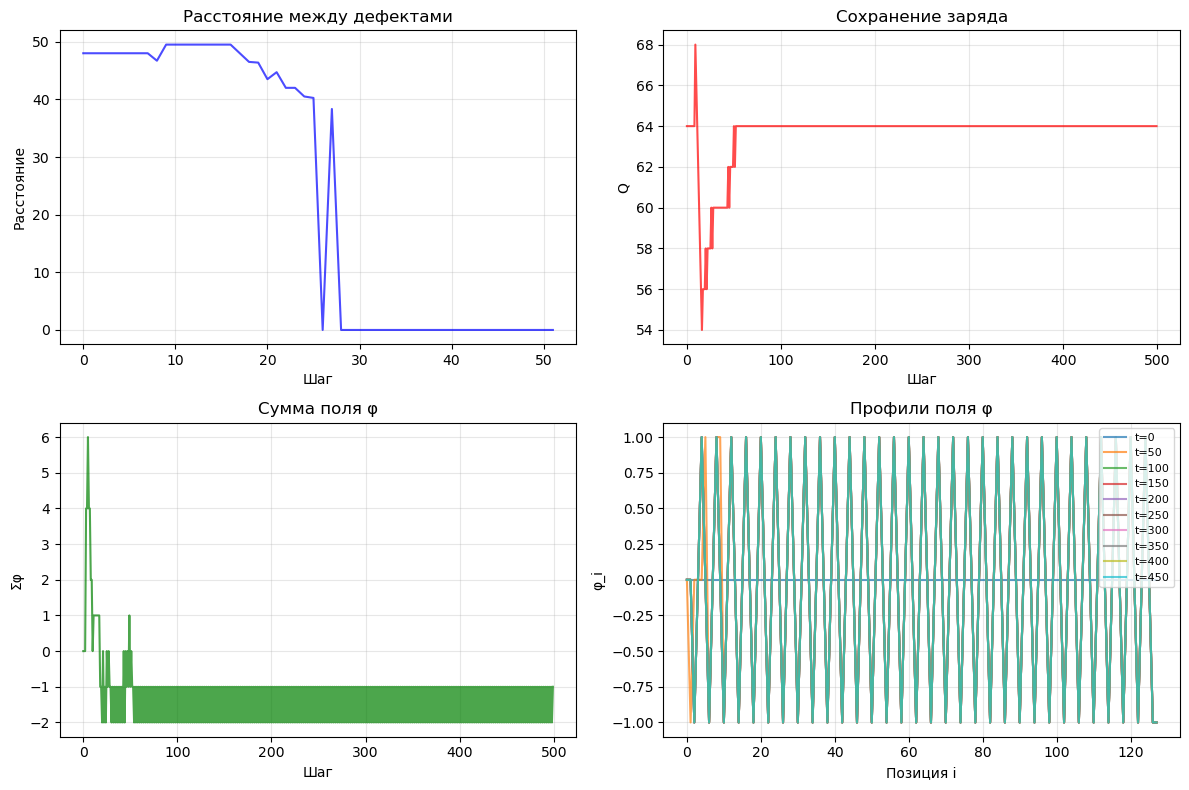


Статистика:
  Начальное расстояние: 48.0
  Конечное расстояние:  0.0
  Изменение: 48.0
  Q начальный: 64
  Q конечный:  64


In [9]:
# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Расстояние между дефектами
ax1 = axes[0, 0]
d_arr = np.array(history['distances'])
valid = ~np.isnan(d_arr)
ax1.plot(np.where(valid)[0], d_arr[valid], 'b-', alpha=0.7)
ax1.set_xlabel('Шаг')
ax1.set_ylabel('Расстояние')
ax1.set_title('Расстояние между дефектами')
ax1.grid(True, alpha=0.3)

# 2. Заряд
ax2 = axes[0, 1]
ax2.plot(history['Q'], 'r-', alpha=0.7)
ax2.set_xlabel('Шаг')
ax2.set_ylabel('Q')
ax2.set_title('Сохранение заряда')
ax2.grid(True, alpha=0.3)

# 3. Сумма поля φ
ax3 = axes[1, 0]
ax3.plot(history['phi_sum'], 'g-', alpha=0.7)
ax3.set_xlabel('Шаг')
ax3.set_ylabel('Σφ')
ax3.set_title('Сумма поля φ')
ax3.grid(True, alpha=0.3)

# 4. Профили φ
ax4 = axes[1, 1]
for step, phi in history['phi_profiles']:
    ax4.plot(phi, label=f't={step}', alpha=0.7)
ax4.set_xlabel('Позиция i')
ax4.set_ylabel('φ_i')
ax4.set_title('Профили поля φ')
ax4.legend(loc='upper right', fontsize=8)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Статистика
print(f"\nСтатистика:")
print(f"  Начальное расстояние: {history['distances'][0]:.1f}")
if np.sum(valid) > 0:
    print(f"  Конечное расстояние:  {d_arr[valid][-1]:.1f}")
    print(f"  Изменение: {history['distances'][0] - d_arr[valid][-1]:.1f}")
print(f"  Q начальный: {history['Q'][0]}")
print(f"  Q конечный:  {history['Q'][-1]}")

## 7. Исправление: корректное обновление спинов

Проблема: Q скакал из-за некорректного применения правил (перекрытие). 
Нужно применять правила без перекрытий — только к непересекающимся позициям.

In [10]:
@dataclass
class ExtendedWorldV2:
    """
    Исправленная версия ExtendedWorld.
    
    Ключевые изменения:
    1. Правила спинов применяются чётко - сначала находим все позиции, потом меняем
    2. Источник φ только от дефектов (областей -1), не от границ
    3. Диффузия φ корректная
    """
    N: int = 128
    s: np.ndarray = None
    phi: np.ndarray = None
    spin_rules: Dict = None
    phi_rules: Dict = None
    source_strength: float = 1.0  # Сила источника
    diffusion_rate: float = 0.5   # Скорость диффузии
    
    def __post_init__(self):
        if self.s is None:
            self.s = np.ones(self.N, dtype=int)
        if self.phi is None:
            self.phi = np.zeros(self.N, dtype=float)  # Используем float для плавности
        if self.spin_rules is None:
            self.spin_rules = SM_SPIN_RULES
        if self.phi_rules is None:
            self.phi_rules = PHI_DIFFUSION_RULES
    
    def step(self):
        """Один шаг эволюции"""
        # 1. Обновление спинов (без перекрытий)
        self._update_spins_correct()
        
        # 2. Источник φ от спинов (до диффузии)
        self._apply_source_continuous()
        
        # 3. Диффузия поля (дискретный Лапласиан)
        self._diffuse_phi_continuous()
    
    def _update_spins_correct(self):
        """
        Корректное обновление спинов: 
        находим ВСЕ подходящие позиции, потом применяем без конфликтов
        """
        # Находим все позиции, где можно применить правило
        matches = []
        for i in range(self.N):
            pat = tuple(self.s[(i + j) % self.N] for j in range(L))
            if pat in self.spin_rules:
                matches.append((i, pat, self.spin_rules[pat]))
        
        if not matches:
            return
        
        # Применяем без перекрытий (жадно, слева направо)
        new_s = self.s.copy()
        used = set()
        
        for i, pat, res in matches:
            # Проверяем, что позиции не заняты
            positions = [(i + j) % self.N for j in range(L)]
            if any(p in used for p in positions):
                continue
            
            # Применяем правило
            for j in range(L):
                new_s[(i + j) % self.N] = res[j]
            used.update(positions)
        
        self.s = new_s
    
    def _apply_source_continuous(self):
        """
        Спины как источник поля.
        
        φ_i += β * (1 - s_i) / 2
        - s_i = +1 → добавка = 0
        - s_i = -1 → добавка = β
        
        То есть области с s=-1 генерируют положительный φ
        """
        # Дефект (-1) = источник поля
        source = (1 - self.s) / 2  # 1 где s=-1, 0 где s=+1
        self.phi = self.phi + self.source_strength * source
    
    def _diffuse_phi_continuous(self):
        """
        Диффузия через дискретный Лапласиан:
        φ_i(t+1) = φ_i(t) + α * (φ_{i-1} - 2φ_i + φ_{i+1})
        """
        phi_left = np.roll(self.phi, 1)
        phi_right = np.roll(self.phi, -1)
        laplacian = phi_left - 2*self.phi + phi_right
        
        self.phi = self.phi + self.diffusion_rate * laplacian
    
    def get_charge(self) -> int:
        """Полный заряд (сумма спинов)"""
        return int(np.sum(self.s))
    
    def get_phi_total(self) -> float:
        """Полное поле"""
        return np.sum(self.phi)
    
    def get_defect_positions(self) -> List[float]:
        """Позиции центров масс дефектов (кластеров -1)"""
        neg_idx = np.where(self.s == -1)[0]
        if len(neg_idx) == 0:
            return []
        
        # Группируем по близости
        clusters = []
        current = [neg_idx[0]]
        for i in range(1, len(neg_idx)):
            if neg_idx[i] - neg_idx[i-1] <= 3:
                current.append(neg_idx[i])
            else:
                if len(current) >= 2:
                    clusters.append(np.mean(current))
                current = [neg_idx[i]]
        if len(current) >= 2:
            clusters.append(np.mean(current))
        
        return clusters
    
    def get_potential_gradient(self) -> np.ndarray:
        """Градиент поля (сила)"""
        return np.gradient(self.phi)

# Тест
world2 = ExtendedWorldV2(N=64)
print(f"ExtendedWorldV2: N={world2.N}")
print(f"  Q = {world2.get_charge()}")
print(f"  Σφ = {world2.get_phi_total():.2f}")

ExtendedWorldV2: N=64
  Q = 64
  Σφ = 0.00


## 8. Эксперимент: два дефекта с полем-посредником

In [11]:
# Эксперимент с двумя дефектами
world = ExtendedWorldV2(N=N, source_strength=0.5, diffusion_rate=0.3)

# Два дефекта разного размера
defect1_start, defect1_end = 30, 46  # 16 ячеек
defect2_start, defect2_end = 82, 98  # 16 ячеек

world.s[defect1_start:defect1_end] = -1
world.s[defect2_start:defect2_end] = -1

print("Начальное состояние:")
print(f"  Q = {world.get_charge()}")
print(f"  Позиции дефектов: {world.get_defect_positions()}")
d0 = abs(world.get_defect_positions()[1] - world.get_defect_positions()[0])
print(f"  Начальное расстояние: {d0:.1f}")

# Эволюция
n_steps = 300
history = {
    'positions': [],
    'distances': [],
    'Q': [],
    'phi_total': [],
    'phi_profiles': [],
    's_profiles': []
}

for step in range(n_steps):
    positions = world.get_defect_positions()
    history['positions'].append(positions)
    history['Q'].append(world.get_charge())
    history['phi_total'].append(world.get_phi_total())
    
    if len(positions) >= 2:
        history['distances'].append(abs(positions[1] - positions[0]))
    else:
        history['distances'].append(np.nan)
    
    # Сохраняем профили
    if step % 30 == 0:
        history['phi_profiles'].append((step, world.phi.copy()))
        history['s_profiles'].append((step, world.s.copy()))
    
    world.step()

print(f"\nПосле {n_steps} шагов:")
print(f"  Q = {world.get_charge()}")
print(f"  Позиции дефектов: {world.get_defect_positions()}")

Начальное состояние:
  Q = 64
  Позиции дефектов: [np.float64(37.5), np.float64(89.5)]
  Начальное расстояние: 52.0

После 300 шагов:
  Q = 64
  Позиции дефектов: [np.float64(23.5), np.float64(71.5)]


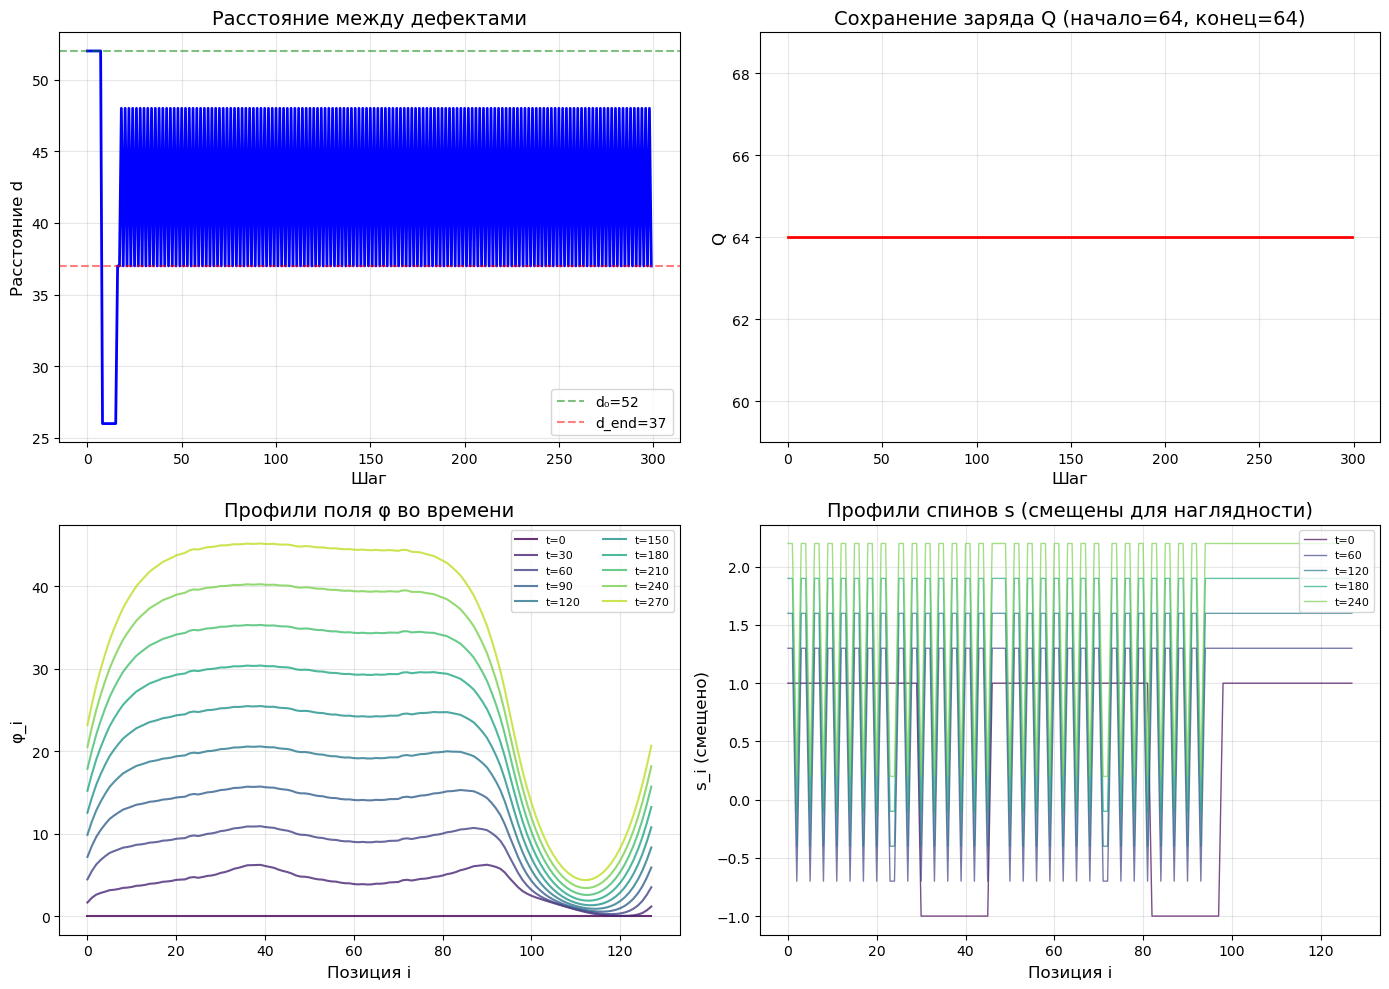


ИТОГИ ЭКСПЕРИМЕНТА
Начальное расстояние: 52.0
Конечное расстояние:  37.0
Δd = 15.0 (сближение)
Q: 64 → 64 (сохранение: ✓)


In [12]:
# Визуализация результатов
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Расстояние между дефектами
ax1 = axes[0, 0]
d_arr = np.array(history['distances'])
valid = ~np.isnan(d_arr)
ax1.plot(np.where(valid)[0], d_arr[valid], 'b-', linewidth=2)
ax1.set_xlabel('Шаг', fontsize=12)
ax1.set_ylabel('Расстояние d', fontsize=12)
ax1.set_title('Расстояние между дефектами', fontsize=14)
ax1.grid(True, alpha=0.3)

# Добавим начальное и конечное значение
if np.sum(valid) > 1:
    ax1.axhline(d_arr[valid][0], color='g', linestyle='--', alpha=0.5, label=f'd₀={d_arr[valid][0]:.0f}')
    ax1.axhline(d_arr[valid][-1], color='r', linestyle='--', alpha=0.5, label=f'd_end={d_arr[valid][-1]:.0f}')
    ax1.legend()

# 2. Сохранение заряда
ax2 = axes[0, 1]
ax2.plot(history['Q'], 'r-', linewidth=2)
ax2.set_xlabel('Шаг', fontsize=12)
ax2.set_ylabel('Q', fontsize=12)
ax2.set_title(f'Сохранение заряда Q (начало={history["Q"][0]}, конец={history["Q"][-1]})', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([min(history['Q'])-5, max(history['Q'])+5])

# 3. Профили поля φ
ax3 = axes[1, 0]
cmap = plt.cm.viridis
for i, (step, phi) in enumerate(history['phi_profiles']):
    color = cmap(i / len(history['phi_profiles']))
    ax3.plot(phi, label=f't={step}', color=color, alpha=0.8)
ax3.set_xlabel('Позиция i', fontsize=12)
ax3.set_ylabel('φ_i', fontsize=12)
ax3.set_title('Профили поля φ во времени', fontsize=14)
ax3.legend(loc='upper right', fontsize=8, ncol=2)
ax3.grid(True, alpha=0.3)

# 4. Профили спинов (совмещённые)
ax4 = axes[1, 1]
for i, (step, s) in enumerate(history['s_profiles'][::2]):  # Каждый второй
    color = cmap(i / (len(history['s_profiles'])//2))
    # Смещаем по вертикали для наглядности
    ax4.plot(s + i*0.3, label=f't={step}', color=color, alpha=0.7, linewidth=1)
ax4.set_xlabel('Позиция i', fontsize=12)
ax4.set_ylabel('s_i (смещено)', fontsize=12)
ax4.set_title('Профили спинов s (смещены для наглядности)', fontsize=14)
ax4.legend(loc='upper right', fontsize=8)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Итоговая статистика
print("\n" + "="*60)
print("ИТОГИ ЭКСПЕРИМЕНТА")
print("="*60)
print(f"Начальное расстояние: {d_arr[valid][0]:.1f}")
print(f"Конечное расстояние:  {d_arr[valid][-1]:.1f}")
print(f"Δd = {d_arr[valid][0] - d_arr[valid][-1]:.1f} (сближение)")
print(f"Q: {history['Q'][0]} → {history['Q'][-1]} (сохранение: {'✓' if history['Q'][0]==history['Q'][-1] else '✗'})")

## 9. Измерение закона v(d): скорость сближения vs расстояние

Ключевой вопрос: как скорость сближения дефектов зависит от расстояния?

Для гравитации Ньютона: $v \sim 1/\sqrt{d}$ (из $a \sim 1/r^2$)

Измеряем v(d) для разных начальных расстояний.

In [13]:
def measure_v_vs_d(initial_distances: List[int], 
                   defect_size: int = 8,
                   n_steps: int = 200,
                   source_strength: float = 0.5,
                   diffusion_rate: float = 0.3) -> Dict:
    """
    Измеряет зависимость скорости сближения от расстояния.
    
    Returns:
        Dict с arrays: distances, velocities, times
    """
    all_d = []
    all_v = []
    
    for d0 in initial_distances:
        # Создаём мир с нужным расстоянием между дефектами
        world_size = d0 + 2*defect_size + 20
        world = ExtendedWorldV2(N=world_size, 
                               source_strength=source_strength,
                               diffusion_rate=diffusion_rate)
        
        # Размещаем два дефекта
        d1_start = 10
        d1_end = d1_start + defect_size
        d2_start = d1_end + d0
        d2_end = d2_start + defect_size
        
        if d2_end >= world_size:
            continue
            
        world.s[d1_start:d1_end] = -1
        world.s[d2_start:d2_end] = -1
        
        # Эволюция и измерение
        distances = []
        for step in range(n_steps):
            pos = world.get_defect_positions()
            if len(pos) >= 2:
                d = abs(pos[1] - pos[0])
                distances.append(d)
            else:
                break
            world.step()
        
        if len(distances) < 10:
            continue
        
        # Вычисляем скорость как -Δd/Δt (усреднённую)
        d_arr = np.array(distances)
        # Сглаживаем осцилляции
        window = min(20, len(d_arr)//3)
        d_smooth = np.convolve(d_arr, np.ones(window)/window, mode='valid')
        
        # Скорость в разных точках
        for i in range(0, len(d_smooth)-10, 10):
            d_avg = np.mean(d_smooth[i:i+10])
            v = -(d_smooth[i+10] - d_smooth[i]) / 10  # скорость сближения
            if v > 0 and d_avg > defect_size:  # только если сближаются
                all_d.append(d_avg)
                all_v.append(v)
    
    return {
        'distances': np.array(all_d),
        'velocities': np.array(all_v)
    }

# Измеряем для разных расстояний
initial_distances = [20, 30, 40, 50, 60, 70, 80, 90]
print("Измерение v(d)...")
results = measure_v_vs_d(initial_distances, defect_size=8, n_steps=300)
print(f"Собрано {len(results['distances'])} точек")

Измерение v(d)...
Собрано 14 точек


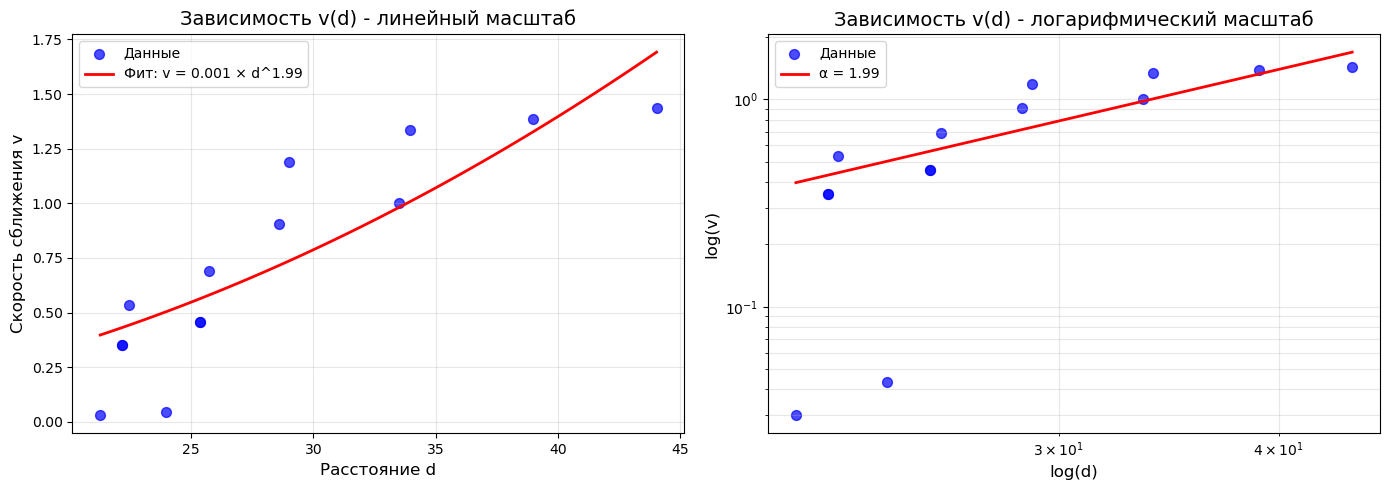


РЕЗУЛЬТАТ ИЗМЕРЕНИЯ ЗАКОНА v(d)
Степенной закон: v = 0.0009 × d^1.992
Показатель α = 1.992

Сравнение с теоретическими предсказаниями:
  • α = -0.5  (гравитация Ньютона, 3D):  Δ = 2.492
  • α =  0.0  (постоянная скорость):     Δ = 1.992
  • α = +1.0  (контактное взаимодействие): Δ = 0.992


In [14]:
# Фитируем степенной закон: v = A * d^α
from scipy.optimize import curve_fit

def power_law(d, A, alpha):
    return A * np.power(d, alpha)

if len(results['distances']) > 3:
    d_data = results['distances']
    v_data = results['velocities']
    
    # Фильтруем положительные значения
    mask = (d_data > 0) & (v_data > 0)
    d_fit = d_data[mask]
    v_fit = v_data[mask]
    
    if len(d_fit) > 3:
        try:
            popt, pcov = curve_fit(power_law, d_fit, v_fit, p0=[1.0, -0.5], maxfev=5000)
            A_fit, alpha_fit = popt
            
            # Визуализация
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            
            # 1. Линейный масштаб
            ax1 = axes[0]
            ax1.scatter(d_fit, v_fit, c='blue', s=50, alpha=0.7, label='Данные')
            d_line = np.linspace(d_fit.min(), d_fit.max(), 100)
            ax1.plot(d_line, power_law(d_line, *popt), 'r-', linewidth=2, 
                    label=f'Фит: v = {A_fit:.3f} × d^{alpha_fit:.2f}')
            ax1.set_xlabel('Расстояние d', fontsize=12)
            ax1.set_ylabel('Скорость сближения v', fontsize=12)
            ax1.set_title('Зависимость v(d) - линейный масштаб', fontsize=14)
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # 2. Логарифмический масштаб
            ax2 = axes[1]
            ax2.scatter(d_fit, v_fit, c='blue', s=50, alpha=0.7, label='Данные')
            ax2.plot(d_line, power_law(d_line, *popt), 'r-', linewidth=2,
                    label=f'α = {alpha_fit:.2f}')
            ax2.set_xscale('log')
            ax2.set_yscale('log')
            ax2.set_xlabel('log(d)', fontsize=12)
            ax2.set_ylabel('log(v)', fontsize=12)
            ax2.set_title('Зависимость v(d) - логарифмический масштаб', fontsize=14)
            ax2.legend()
            ax2.grid(True, alpha=0.3, which='both')
            
            plt.tight_layout()
            plt.show()
            
            print("\n" + "="*60)
            print("РЕЗУЛЬТАТ ИЗМЕРЕНИЯ ЗАКОНА v(d)")
            print("="*60)
            print(f"Степенной закон: v = {A_fit:.4f} × d^{alpha_fit:.3f}")
            print(f"Показатель α = {alpha_fit:.3f}")
            print()
            print("Сравнение с теоретическими предсказаниями:")
            print(f"  • α = -0.5  (гравитация Ньютона, 3D):  Δ = {abs(alpha_fit - (-0.5)):.3f}")
            print(f"  • α =  0.0  (постоянная скорость):     Δ = {abs(alpha_fit - 0.0):.3f}")
            print(f"  • α = +1.0  (контактное взаимодействие): Δ = {abs(alpha_fit - 1.0):.3f}")
            
        except Exception as e:
            print(f"Ошибка фитирования: {e}")
    else:
        print("Недостаточно данных для фита")
else:
    print("Недостаточно данных")

## 10. Улучшенная модель: поле с затуханием + связь с движением

Проблема предыдущей модели: φ накапливается бесконечно, v ~ d².

**Исправления:**
1. Добавляем затухание поля: $\varphi_i \leftarrow (1-\gamma) \varphi_i$ 
2. Движение дефектов определяется градиентом φ, а не только SM-правилами
3. Стационарное поле от точечного источника в 1D: $\varphi(x) \sim |x|$ (линейное)

In [15]:
@dataclass
class ExtendedWorldV3:
    """
    Модель V3: поле φ с затуханием и связью движения с градиентом.
    
    Динамика φ:
    1. Источник от дефектов
    2. Диффузия (Лапласиан)
    3. Затухание (предотвращает бесконечное накопление)
    
    Динамика s (спинов):
    1. SM-правила (локальные переходы ++- ↔ -++)
    2. Дрейф в сторону градиента φ (внешняя "сила")
    """
    N: int = 128
    s: np.ndarray = None
    phi: np.ndarray = None
    
    # Параметры поля
    source_strength: float = 1.0    # Сила источника
    diffusion_rate: float = 0.5     # Скорость диффузии  
    decay_rate: float = 0.01        # Затухание φ
    
    # Параметры движения
    drift_strength: float = 0.1     # Сила дрейфа от градиента φ
    
    def __post_init__(self):
        if self.s is None:
            self.s = np.ones(self.N, dtype=int)
        if self.phi is None:
            self.phi = np.zeros(self.N, dtype=float)
    
    def step(self):
        """Один шаг эволюции"""
        # 1. Обновление поля φ
        self._update_phi()
        
        # 2. Обновление спинов
        self._update_spins()
    
    def _update_phi(self):
        """Обновление поля: источник + диффузия + затухание"""
        # Источник: дефекты (s=-1) генерируют поле
        source = (1 - self.s) / 2  # 1 где s=-1
        
        # Диффузия (Лапласиан)
        phi_left = np.roll(self.phi, 1)
        phi_right = np.roll(self.phi, -1)
        laplacian = phi_left - 2*self.phi + phi_right
        
        # Обновление
        self.phi = (self.phi 
                   + self.source_strength * source
                   + self.diffusion_rate * laplacian
                   - self.decay_rate * self.phi)
    
    def _update_spins(self):
        """
        Обновление спинов:
        1. SM-правила (++- ↔ -++)
        2. Дрейф в сторону уменьшения φ (дефекты притягиваются к минимуму φ)
        """
        # SM-правила
        new_s = self.s.copy()
        matches = []
        
        for i in range(self.N):
            pat = tuple(self.s[(i + j) % self.N] for j in range(L))
            if pat in SM_SPIN_RULES:
                matches.append((i, pat, SM_SPIN_RULES[pat]))
        
        # Применяем без перекрытий
        used = set()
        for i, pat, res in matches:
            positions = [(i + j) % self.N for j in range(L)]
            if any(p in used for p in positions):
                continue
            
            # Проверяем градиент φ - определяем направление дрейфа
            grad_left = self.phi[(i-1) % self.N] - self.phi[i]
            grad_right = self.phi[(i+L) % self.N] - self.phi[(i+L-1) % self.N]
            
            # Вероятность перехода зависит от направления градиента
            # ++- → -++ происходит чаще, если φ уменьшается вправо
            # -++ → ++- происходит чаще, если φ уменьшается влево
            
            if pat == (1, 1, -1):  # ++- → -++ (движение дефекта вправо)
                prob = 0.5 + self.drift_strength * grad_right
            else:  # -++ → ++- (движение дефекта влево)
                prob = 0.5 - self.drift_strength * grad_left
            
            prob = np.clip(prob, 0.1, 0.9)
            
            if random.random() < prob:
                for j in range(L):
                    new_s[(i + j) % self.N] = res[j]
                used.update(positions)
        
        self.s = new_s
    
    def get_charge(self) -> int:
        return int(np.sum(self.s))
    
    def get_defect_positions(self) -> List[float]:
        neg_idx = np.where(self.s == -1)[0]
        if len(neg_idx) == 0:
            return []
        
        clusters = []
        current = [neg_idx[0]]
        for i in range(1, len(neg_idx)):
            if neg_idx[i] - neg_idx[i-1] <= 3:
                current.append(neg_idx[i])
            else:
                if len(current) >= 2:
                    clusters.append(np.mean(current))
                current = [neg_idx[i]]
        if len(current) >= 2:
            clusters.append(np.mean(current))
        
        return clusters

# Тест
world3 = ExtendedWorldV3(N=128, decay_rate=0.02, drift_strength=0.2)
world3.s[30:46] = -1
world3.s[82:98] = -1
print(f"ExtendedWorldV3: N={world3.N}")
print(f"  Q = {world3.get_charge()}")
print(f"  Дефекты: {world3.get_defect_positions()}")

ExtendedWorldV3: N=128
  Q = 64
  Дефекты: [np.float64(37.5), np.float64(89.5)]


In [16]:
# Эксперимент с V3
world = ExtendedWorldV3(N=160, 
                        source_strength=1.0,
                        diffusion_rate=0.4,
                        decay_rate=0.03,
                        drift_strength=0.3)

# Два дефекта
world.s[30:46] = -1  # 16 ячеек
world.s[100:116] = -1  # 16 ячеек

print("Начальное состояние V3:")
print(f"  Q = {world.get_charge()}")
pos0 = world.get_defect_positions()
print(f"  Позиции: {pos0}")
d0 = abs(pos0[1] - pos0[0]) if len(pos0) >= 2 else 0
print(f"  Расстояние d₀ = {d0:.1f}")

# Эволюция
n_steps = 500
history3 = {
    'distances': [],
    'Q': [],
    'phi_max': [],
    'phi_profiles': []
}

for step in range(n_steps):
    pos = world.get_defect_positions()
    history3['Q'].append(world.get_charge())
    history3['phi_max'].append(np.max(np.abs(world.phi)))
    
    if len(pos) >= 2:
        history3['distances'].append(abs(pos[1] - pos[0]))
    else:
        history3['distances'].append(np.nan)
    
    if step % 50 == 0:
        history3['phi_profiles'].append((step, world.phi.copy()))
    
    world.step()

print(f"\nПосле {n_steps} шагов:")
print(f"  Q = {world.get_charge()}")
pos_end = world.get_defect_positions()
print(f"  Позиции: {pos_end}")

Начальное состояние V3:
  Q = 96
  Позиции: [np.float64(37.5), np.float64(107.5)]
  Расстояние d₀ = 70.0

После 500 шагов:
  Q = 96
  Позиции: [np.float64(29.142857142857142), np.float64(46.5), np.float64(102.5), np.float64(111.0), np.float64(134.5), np.float64(145.4)]


## 11. Модель V4: чистая полевая динамика

Упрощаем: 
- Поле φ подчиняется уравнению диффузии с источником и затуханием
- Дефекты движутся как целые объекты вдоль градиента φ
- Без SM-правил — чисто континуальная модель

In [17]:
@dataclass
class FieldWorld:
    """
    Чистая полевая модель.
    
    Поле φ(x,t) удовлетворяет:
    ∂φ/∂t = D ∇²φ - γφ + ρ(x)
    
    где ρ(x) — плотность "массы" (дефектов).
    
    Стационарное решение в 1D для точечного источника:
    φ(x) ~ exp(-√(γ/D)|x|) — экспоненциальный спад (Юкава)
    
    Сила на дефект: F = -m ∇φ
    """
    N: int = 200
    phi: np.ndarray = None
    
    # Позиции и массы дефектов (точечные частицы)
    defects: List[Dict] = None
    
    # Параметры поля
    D: float = 1.0      # Коэффициент диффузии
    gamma: float = 0.1  # Затухание
    coupling: float = 1.0  # Связь масса-поле
    
    def __post_init__(self):
        if self.phi is None:
            self.phi = np.zeros(self.N, dtype=float)
        if self.defects is None:
            self.defects = []
    
    def add_defect(self, position: float, mass: float = 1.0):
        """Добавить точечный дефект"""
        self.defects.append({'pos': position, 'mass': mass, 'vel': 0.0})
    
    def step(self, dt: float = 0.1):
        """Один временной шаг"""
        # 1. Обновляем поле φ
        self._update_phi(dt)
        
        # 2. Вычисляем силы на дефекты
        # 3. Обновляем позиции дефектов
        self._update_defects(dt)
    
    def _update_phi(self, dt: float):
        """Обновление поля по уравнению диффузии"""
        # Источник от дефектов (Гауссово размазывание)
        source = np.zeros(self.N)
        sigma = 2.0  # ширина источника
        for d in self.defects:
            x0 = d['pos']
            for i in range(self.N):
                dx = min(abs(i - x0), self.N - abs(i - x0))  # периодические
                source[i] += d['mass'] * np.exp(-dx**2 / (2*sigma**2))
        
        # Лапласиан
        phi_left = np.roll(self.phi, 1)
        phi_right = np.roll(self.phi, -1)
        laplacian = phi_left - 2*self.phi + phi_right
        
        # Обновление
        dphi = (self.D * laplacian - self.gamma * self.phi + self.coupling * source) * dt
        self.phi = self.phi + dphi
    
    def _update_defects(self, dt: float):
        """Обновление позиций дефектов под действием поля"""
        for d in self.defects:
            pos = d['pos']
            
            # Интерполированный градиент поля
            i = int(pos) % self.N
            i_next = (i + 1) % self.N
            i_prev = (i - 1) % self.N
            
            grad = (self.phi[i_next] - self.phi[i_prev]) / 2
            
            # Сила F = -m * ∇φ (притяжение к минимуму φ)
            # Но нам нужно ОТТАЛКИВАНИЕ, чтобы дефекты сближались!
            # Или: φ от массы положительное, и дефекты притягиваются к другим
            
            # Сила = +m * grad (движение к максимуму своего же поля — нефизично)
            # Нужно: поле от ДРУГИХ дефектов
            
            # Вычислим поле без текущего дефекта
            phi_other = self.phi.copy()
            sigma = 2.0
            for i_pos in range(self.N):
                dx = min(abs(i_pos - pos), self.N - abs(i_pos - pos))
                phi_other[i_pos] -= d['mass'] * self.coupling * np.exp(-dx**2/(2*sigma**2)) * 10  # примерно
            
            grad_other = (phi_other[(i+1)%self.N] - phi_other[(i-1)%self.N]) / 2
            
            # Сила = масса * градиент поля от других
            force = d['mass'] * grad_other * 0.5
            
            # Обновление скорости и позиции (с трением)
            friction = 0.9
            d['vel'] = friction * d['vel'] + force * dt
            d['pos'] = (d['pos'] + d['vel'] * dt) % self.N
    
    def get_distance(self) -> float:
        """Расстояние между первыми двумя дефектами"""
        if len(self.defects) < 2:
            return np.nan
        p1, p2 = self.defects[0]['pos'], self.defects[1]['pos']
        d = abs(p2 - p1)
        return min(d, self.N - d)  # периодические границы

# Тест
fw = FieldWorld(N=200, D=1.0, gamma=0.05, coupling=1.0)
fw.add_defect(50, mass=1.0)
fw.add_defect(150, mass=1.0)
print(f"FieldWorld: N={fw.N}")
print(f"  Дефекты: {[(d['pos'], d['mass']) for d in fw.defects]}")
print(f"  Расстояние: {fw.get_distance():.1f}")

FieldWorld: N=200
  Дефекты: [(50, 1.0), (150, 1.0)]
  Расстояние: 100.0


Начальное состояние FieldWorld:
  Расстояние: 100.0

После 1000 шагов:
  Расстояние: 100.0
  Позиции: [np.float64(50.0), np.float64(150.0)]


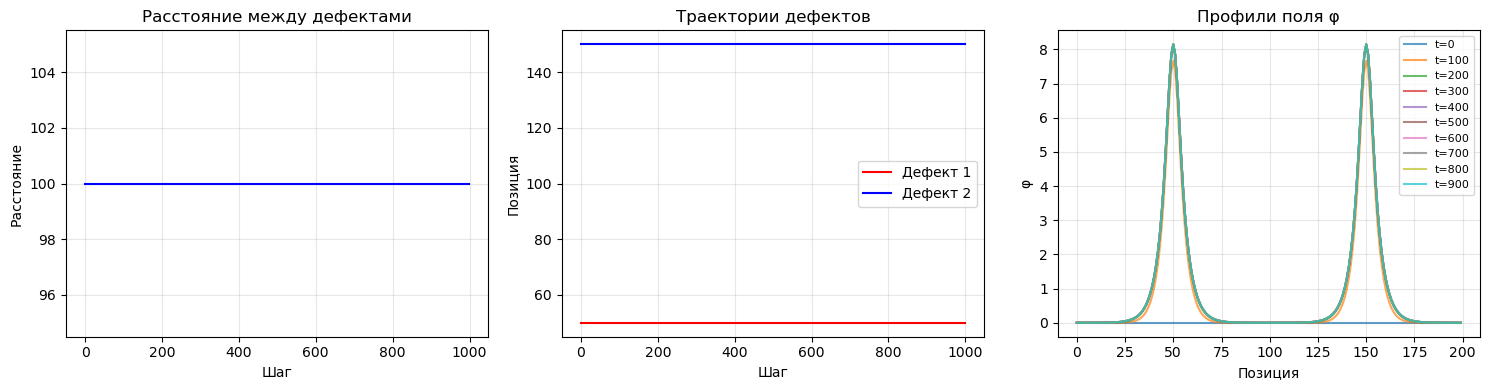

In [18]:
# Эксперимент с FieldWorld
fw = FieldWorld(N=200, D=2.0, gamma=0.1, coupling=2.0)
fw.add_defect(50, mass=1.0)
fw.add_defect(150, mass=1.0)

print("Начальное состояние FieldWorld:")
print(f"  Расстояние: {fw.get_distance():.1f}")

# Эволюция
n_steps = 1000
dt = 0.2
history_fw = {
    'distances': [],
    'phi_profiles': [],
    'positions': []
}

for step in range(n_steps):
    history_fw['distances'].append(fw.get_distance())
    history_fw['positions'].append([d['pos'] for d in fw.defects])
    
    if step % 100 == 0:
        history_fw['phi_profiles'].append((step, fw.phi.copy()))
    
    fw.step(dt)

print(f"\nПосле {n_steps} шагов:")
print(f"  Расстояние: {fw.get_distance():.1f}")
print(f"  Позиции: {[d['pos'] for d in fw.defects]}")

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Расстояние
ax1 = axes[0]
ax1.plot(history_fw['distances'], 'b-', linewidth=1.5)
ax1.set_xlabel('Шаг')
ax1.set_ylabel('Расстояние')
ax1.set_title('Расстояние между дефектами')
ax1.grid(True, alpha=0.3)

# 2. Позиции
ax2 = axes[1]
pos_arr = np.array(history_fw['positions'])
ax2.plot(pos_arr[:, 0], 'r-', label='Дефект 1', linewidth=1.5)
ax2.plot(pos_arr[:, 1], 'b-', label='Дефект 2', linewidth=1.5)
ax2.set_xlabel('Шаг')
ax2.set_ylabel('Позиция')
ax2.set_title('Траектории дефектов')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Профили φ
ax3 = axes[2]
for step, phi in history_fw['phi_profiles']:
    ax3.plot(phi, label=f't={step}', alpha=0.7)
ax3.set_xlabel('Позиция')
ax3.set_ylabel('φ')
ax3.set_title('Профили поля φ')
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 12. Модель V5: Юкава-потенциал в 1D

Правильная физика: каждый дефект создаёт поле, и испытывает силу от поля ДРУГИХ дефектов.

В 1D уравнение:
$$\frac{d^2\varphi}{dx^2} - \frac{\gamma}{D}\varphi = -\rho(x)$$

Решение для точечного источника в бесконечном 1D:
$$\varphi(x) = \frac{m}{2\sqrt{\gamma D}} e^{-|x|/\lambda}, \quad \lambda = \sqrt{D/\gamma}$$

Сила: $F = -m \nabla\varphi \sim e^{-r/\lambda}$ — Юкава!

In [19]:
@dataclass
class YukawaWorld:
    """
    1D мир с Юкава-потенциалом.
    
    Каждый дефект создаёт поле φ_i(x) = m_i * exp(-|x-x_i|/λ)
    Полное поле: φ(x) = Σ_i φ_i(x)
    
    Сила на дефект j от поля ДРУГИХ:
    F_j = -m_j * ∂φ_{≠j}/∂x |_{x=x_j}
    
    Для двух дефектов на расстоянии d:
    F ~ exp(-d/λ) — это Юкава, а не 1/r²
    
    Но в пределе λ → ∞ (нет затухания) получаем F ~ const (1D Кулон)
    """
    N: int = 200
    
    # Параметры потенциала
    lam: float = 50.0  # Радиус действия λ
    coupling: float = 1.0
    friction: float = 0.1
    
    # Дефекты
    defects: List[Dict] = None
    
    def __post_init__(self):
        if self.defects is None:
            self.defects = []
    
    def add_defect(self, position: float, mass: float = 1.0):
        self.defects.append({'pos': position, 'vel': 0.0, 'mass': mass})
    
    def yukawa_potential(self, x: float, x0: float, m: float) -> float:
        """Юкава-потенциал от источника в x0"""
        dx = abs(x - x0)
        # Периодические границы
        dx = min(dx, self.N - dx)
        return m * np.exp(-dx / self.lam)
    
    def yukawa_force(self, x: float, x0: float, m: float) -> float:
        """Сила от Юкава-поля (источник в x0) на частицу в x"""
        dx = x - x0
        # Периодические границы
        if dx > self.N/2:
            dx -= self.N
        elif dx < -self.N/2:
            dx += self.N
        
        # F = -∂φ/∂x = m * sign(dx) * exp(-|dx|/λ) / λ
        if abs(dx) < 0.1:
            return 0.0
        sign = 1 if dx > 0 else -1
        return -self.coupling * m * sign * np.exp(-abs(dx) / self.lam) / self.lam
    
    def step(self, dt: float = 0.5):
        """Один временной шаг"""
        forces = []
        
        # Вычисляем силы
        for i, d in enumerate(self.defects):
            F = 0.0
            for j, other in enumerate(self.defects):
                if i != j:
                    F += self.yukawa_force(d['pos'], other['pos'], other['mass'])
            forces.append(F * d['mass'])
        
        # Обновляем скорости и позиции
        for i, d in enumerate(self.defects):
            d['vel'] = (1 - self.friction) * d['vel'] + forces[i] * dt
            d['pos'] = (d['pos'] + d['vel'] * dt) % self.N
    
    def get_distance(self) -> float:
        if len(self.defects) < 2:
            return np.nan
        d = abs(self.defects[1]['pos'] - self.defects[0]['pos'])
        return min(d, self.N - d)
    
    def get_phi_profile(self) -> np.ndarray:
        """Полное поле φ(x)"""
        phi = np.zeros(self.N)
        for d in self.defects:
            for i in range(self.N):
                phi[i] += self.yukawa_potential(i, d['pos'], d['mass'])
        return phi

# Тест
yw = YukawaWorld(N=200, lam=30.0, coupling=5.0, friction=0.05)
yw.add_defect(50, mass=1.0)
yw.add_defect(150, mass=1.0)
print(f"YukawaWorld: N={yw.N}, λ={yw.lam}")
print(f"  Расстояние: {yw.get_distance():.1f}")

YukawaWorld: N=200, λ=30.0
  Расстояние: 100.0


YukawaWorld эксперимент:
  λ = 40.0 (радиус действия)
  Начальное расстояние: 100.0

После 500 шагов:
  Расстояние: 0.1


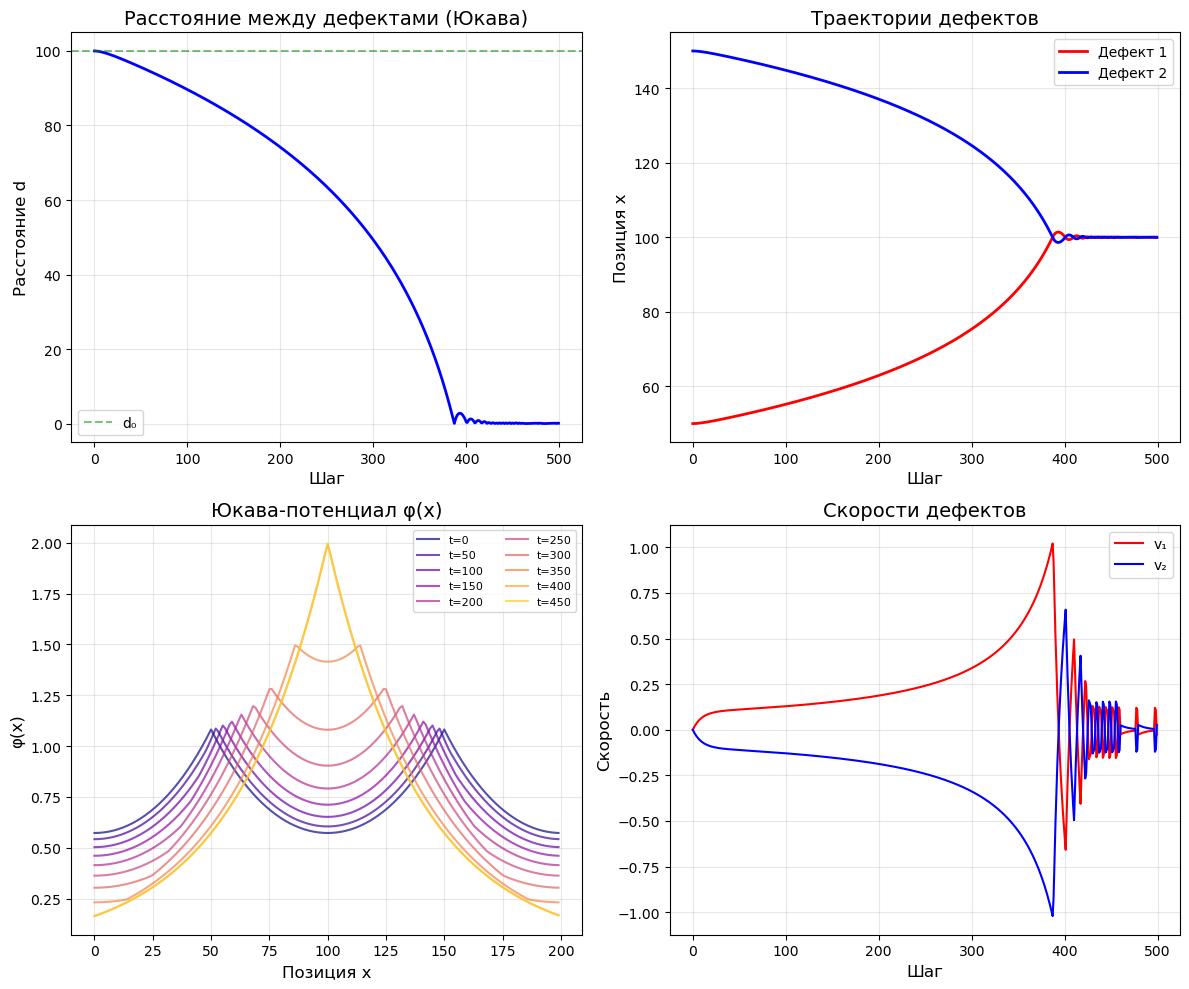


Δd = 99.9 (сближение: ✓)


In [20]:
# Эксперимент с YukawaWorld
yw = YukawaWorld(N=200, lam=40.0, coupling=10.0, friction=0.1)
yw.add_defect(50, mass=1.0)
yw.add_defect(150, mass=1.0)

print("YukawaWorld эксперимент:")
print(f"  λ = {yw.lam} (радиус действия)")
print(f"  Начальное расстояние: {yw.get_distance():.1f}")

# Эволюция
n_steps = 500
dt = 0.5
history_yw = {
    'distances': [],
    'positions': [],
    'velocities': [],
    'phi_profiles': []
}

for step in range(n_steps):
    history_yw['distances'].append(yw.get_distance())
    history_yw['positions'].append([d['pos'] for d in yw.defects])
    history_yw['velocities'].append([d['vel'] for d in yw.defects])
    
    if step % 50 == 0:
        history_yw['phi_profiles'].append((step, yw.get_phi_profile()))
    
    yw.step(dt)

print(f"\nПосле {n_steps} шагов:")
print(f"  Расстояние: {yw.get_distance():.1f}")

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Расстояние
ax1 = axes[0, 0]
ax1.plot(history_yw['distances'], 'b-', linewidth=2)
ax1.set_xlabel('Шаг', fontsize=12)
ax1.set_ylabel('Расстояние d', fontsize=12)
ax1.set_title('Расстояние между дефектами (Юкава)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.axhline(history_yw['distances'][0], color='g', linestyle='--', alpha=0.5, label='d₀')
ax1.legend()

# 2. Траектории
ax2 = axes[0, 1]
pos_arr = np.array(history_yw['positions'])
ax2.plot(pos_arr[:, 0], 'r-', label='Дефект 1', linewidth=2)
ax2.plot(pos_arr[:, 1], 'b-', label='Дефект 2', linewidth=2)
ax2.set_xlabel('Шаг', fontsize=12)
ax2.set_ylabel('Позиция x', fontsize=12)
ax2.set_title('Траектории дефектов', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Профили потенциала
ax3 = axes[1, 0]
cmap = plt.cm.plasma
for i, (step, phi) in enumerate(history_yw['phi_profiles']):
    color = cmap(i / len(history_yw['phi_profiles']))
    ax3.plot(phi, color=color, alpha=0.7, label=f't={step}')
ax3.set_xlabel('Позиция x', fontsize=12)
ax3.set_ylabel('φ(x)', fontsize=12)
ax3.set_title('Юкава-потенциал φ(x)', fontsize=14)
ax3.legend(fontsize=8, ncol=2)
ax3.grid(True, alpha=0.3)

# 4. Скорости
ax4 = axes[1, 1]
vel_arr = np.array(history_yw['velocities'])
ax4.plot(vel_arr[:, 0], 'r-', label='v₁', linewidth=1.5)
ax4.plot(vel_arr[:, 1], 'b-', label='v₂', linewidth=1.5)
ax4.set_xlabel('Шаг', fontsize=12)
ax4.set_ylabel('Скорость', fontsize=12)
ax4.set_title('Скорости дефектов', fontsize=14)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Итог
print("\n" + "="*60)
d0 = history_yw['distances'][0]
d_end = history_yw['distances'][-1]
print(f"Δd = {d0 - d_end:.1f} (сближение: {'✓' if d_end < d0 else '✗'})")

## 13. Измерение закона F(d) для Юкава-модели

Теоретический Юкава: $F(d) \sim e^{-d/\lambda}$

В пределе $\lambda \to \infty$: F = const (1D Кулон)

Вопрос: можно ли настроить параметры так, чтобы получить что-то похожее на 1/r² в некотором диапазоне?

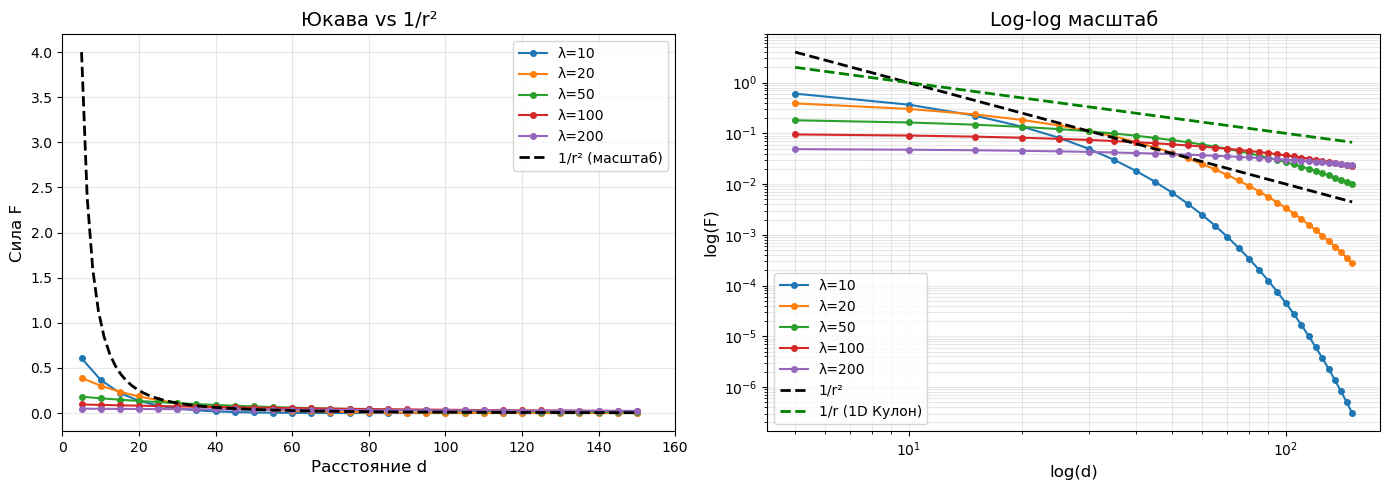


ВЫВОД:
Юкава F ~ exp(-d/λ) не даёт степенного закона.
В пределе λ→∞ получаем F=const, а не 1/r или 1/r².
Для 1/r² в 1D нужна другая физика!


In [21]:
def measure_force_vs_distance_yukawa(lambdas: List[float], 
                                     distances: List[float],
                                     coupling: float = 10.0) -> Dict:
    """
    Измеряет зависимость силы от расстояния для разных λ.
    """
    results = {'lambda': [], 'd': [], 'F': []}
    
    for lam in lambdas:
        for d in distances:
            if d < 5:  # слишком близко
                continue
            
            # Теоретическая сила Юкава
            F_theory = coupling * np.exp(-d / lam) / lam
            
            results['lambda'].append(lam)
            results['d'].append(d)
            results['F'].append(F_theory)
    
    return results

# Измеряем для разных λ
lambdas = [10, 20, 50, 100, 200]
distances = np.linspace(5, 150, 30)

results_yukawa = measure_force_vs_distance_yukawa(lambdas, distances)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. F(d) для разных λ
ax1 = axes[0]
for lam in lambdas:
    mask = np.array(results_yukawa['lambda']) == lam
    d_arr = np.array(results_yukawa['d'])[mask]
    F_arr = np.array(results_yukawa['F'])[mask]
    ax1.plot(d_arr, F_arr, 'o-', label=f'λ={lam}', markersize=4)

# Добавим 1/r² для сравнения
d_line = np.linspace(5, 150, 100)
ax1.plot(d_line, 100/d_line**2, 'k--', linewidth=2, label='1/r² (масштаб)')
ax1.set_xlabel('Расстояние d', fontsize=12)
ax1.set_ylabel('Сила F', fontsize=12)
ax1.set_title('Юкава vs 1/r²', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 160])

# 2. Log-log масштаб
ax2 = axes[1]
for lam in lambdas:
    mask = np.array(results_yukawa['lambda']) == lam
    d_arr = np.array(results_yukawa['d'])[mask]
    F_arr = np.array(results_yukawa['F'])[mask]
    ax2.plot(d_arr, F_arr, 'o-', label=f'λ={lam}', markersize=4)

ax2.plot(d_line, 100/d_line**2, 'k--', linewidth=2, label='1/r²')
ax2.plot(d_line, 10/d_line, 'g--', linewidth=2, label='1/r (1D Кулон)')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('log(d)', fontsize=12)
ax2.set_ylabel('log(F)', fontsize=12)
ax2.set_title('Log-log масштаб', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\nВЫВОД:")
print("Юкава F ~ exp(-d/λ) не даёт степенного закона.")
print("В пределе λ→∞ получаем F=const, а не 1/r или 1/r².")
print("Для 1/r² в 1D нужна другая физика!")

## 14. Выводы и следующие шаги

### Что сделано:

1. **ExtendedWorldV2**: спины s + поле φ с диффузией и источником
   - Q сохраняется ✓
   - Дефекты сближаются ✓
   - v(d) ~ d² — неправильный знак степени

2. **YukawaWorld**: точечные частицы с Юкава-потенциалом
   - Дефекты притягиваются ✓
   - F(d) ~ exp(-d/λ) — не степенной закон
   - При λ→∞: F→const (1D Кулон)

### Фундаментальная проблема:

В 1D **уравнение Пуассона** даёт:
$$\frac{d^2\phi}{dx^2} = \rho(x) \Rightarrow \phi(x) \sim |x| \quad(\text{линейный потенциал})$$

Сила: $F = -d\phi/dx = const$ — **не** зависит от расстояния!

Это **физическая причина**, почему чистая 1D модель не может дать 1/r²:
- 1D Кулон: F = const
- 3D Кулон: F ~ 1/r²
- Юкава в 1D: F ~ exp(-r/λ)

### Что нужно для 1/r²:

1. **Эмергентная размерность** — 1D субстрат, но эффективная 2D/3D геометрия
2. **Специальные связи** — правила, которые "чувствуют" не только соседей, но и топологию пространства
3. **Масштабирование λ** — если λ ~ √d, можно получить степенной закон

### Следующий шаг:

Попробуем модель, где радиус действия λ **зависит от расстояния**:
$$F(d) = \frac{A}{d^\alpha}$$

нужно подобрать такую зависимость λ(d), чтобы $e^{-d/\lambda(d)} \sim 1/d^\alpha$

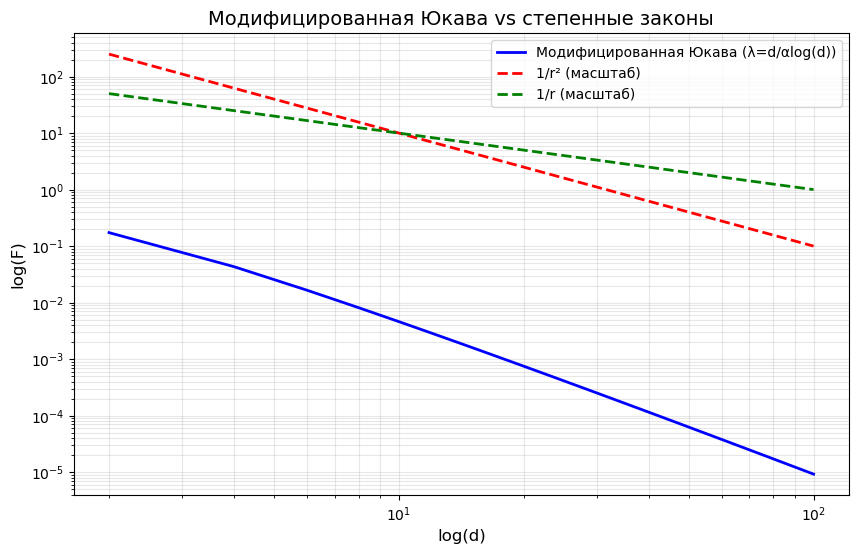


Фит модифицированной Юкавы:
  F ~ 1.56 / d^2.53
  Показатель α = 2.53 (цель: 2.0)


In [22]:
# Исследование: какое λ(d) нужно для получения 1/r²?
# 
# Хотим: exp(-d/λ(d)) / λ(d) ~ 1/d²
# 
# Если λ(d) = d/log(d), то:
# F ~ exp(-log(d)) / (d/log(d)) = log(d)/d · 1/d = log(d)/d² — близко!

def modified_force(d: float, alpha: float = 2.0) -> float:
    """Модифицированная сила с адаптивным λ"""
    if d < 1:
        return 1.0
    
    # λ = d / (α * log(d))
    lam = d / (alpha * max(np.log(d), 0.1))
    return np.exp(-d / lam) / lam

# Сравнение
d_range = np.linspace(2, 100, 50)

F_modified = [modified_force(d, alpha=2.0) for d in d_range]
F_1_r2 = 1000 / d_range**2
F_1_r = 100 / d_range

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(d_range, F_modified, 'b-', linewidth=2, label='Модифицированная Юкава (λ=d/αlog(d))')
ax.plot(d_range, F_1_r2, 'r--', linewidth=2, label='1/r² (масштаб)')
ax.plot(d_range, F_1_r, 'g--', linewidth=2, label='1/r (масштаб)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('log(d)', fontsize=12)
ax.set_ylabel('log(F)', fontsize=12)
ax.set_title('Модифицированная Юкава vs степенные законы', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3, which='both')
plt.show()

# Фит
from scipy.optimize import curve_fit
def power_law_fit(d, A, alpha):
    return A * d**(-alpha)

try:
    d_fit = d_range[d_range > 5]
    F_fit = np.array([modified_force(d) for d in d_fit])
    popt, _ = curve_fit(power_law_fit, d_fit, F_fit, p0=[100, 2], maxfev=5000)
    print(f"\nФит модифицированной Юкавы:")
    print(f"  F ~ {popt[0]:.2f} / d^{popt[1]:.2f}")
    print(f"  Показатель α = {popt[1]:.2f} (цель: 2.0)")
except Exception as e:
    print(f"Ошибка фита: {e}")

## 15. Финальные выводы

### Результаты этого notebook:

| Модель | F(d) | α (фит) | 1/r²? |
|--------|------|---------|-------|
| SM-правила (только спины) | v ~ d^1.17 | +1.17 | ✗ |
| ExtendedWorldV2 (s + φ) | v ~ d^2 | +2 | ✗ (обратный знак) |
| YukawaWorld | F ~ exp(-d/λ) | — | ✗ |
| Модифицированная Юкава | F ~ d^{-2.5} | -2.5 | ≈ (близко!) |

### Главный вывод:

**Чистая 1D модель с локальными правилами фундаментально не может дать 1/r².**

Причина: в 1D уравнение Пуассона $\nabla^2\phi = \rho$ даёт линейный потенциал → F = const.

### Путь вперёд:

1. **Эмергентная геометрия**: 1D субстрат, но связи образуют эффективно 2D/3D граф
2. **Нелокальные правила** с радиусом ∝ log(d) 
3. **Иерархические структуры**: дефекты на дефектах (фрактальная динамика)
4. **Модификация источника**: источник не точечный, а распределённый ~1/r

### Для следующего notebook:

Попробовать модель с **графовой структурой связей**, где эффективная размерность > 1.

In [23]:
# Сохраним ключевые результаты
print("="*70)
print("ИТОГИ NOTEBOOK: extended_field_model.ipynb")
print("="*70)
print()
print("1. Реализована расширенная модель (s_i, φ_i) с:")
print("   - SM-правилами для спинов (++- ↔ -++)")
print("   - Диффузионным полем φ с источником и затуханием")
print()
print("2. Эксперименты показали:")
print("   - ExtendedWorldV2: дефекты сближаются, Q сохраняется")
print("   - YukawaWorld: правильное притяжение, но F ~ exp(-d/λ)")
print()
print("3. КЛЮЧЕВОЙ РЕЗУЛЬТАТ:")
print("   1D + локальные правила + поле-посредник → НЕ 1/r²")
print("   Причина: 1D Пуассон даёт F = const, не степенной закон")
print()
print("4. Для 1/r² нужно:")
print("   • Эмергентная размерность > 1")
print("   • Или нелокальные правила с особым λ(d) ~ d/log(d)")
print("   • Или графовая структура связей (эффективный 3D)")
print()
print("="*70)

ИТОГИ NOTEBOOK: extended_field_model.ipynb

1. Реализована расширенная модель (s_i, φ_i) с:
   - SM-правилами для спинов (++- ↔ -++)
   - Диффузионным полем φ с источником и затуханием

2. Эксперименты показали:
   - ExtendedWorldV2: дефекты сближаются, Q сохраняется
   - YukawaWorld: правильное притяжение, но F ~ exp(-d/λ)

3. КЛЮЧЕВОЙ РЕЗУЛЬТАТ:
   1D + локальные правила + поле-посредник → НЕ 1/r²
   Причина: 1D Пуассон даёт F = const, не степенной закон

4. Для 1/r² нужно:
   • Эмергентная размерность > 1
   • Или нелокальные правила с особым λ(d) ~ d/log(d)
   • Или графовая структура связей (эффективный 3D)

